<a href="https://colab.research.google.com/github/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_bert_sentiment_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

First, set up the required Python modules and perform some general configuration.

(This part of the code follows the [MLP notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_mlp.ipynb) that you should already be familiar with.)

Install the required Python packages using [pip](https://en.wikipedia.org/wiki/Pip):

* [`transformers`](https://huggingface.co/docs/transformers/index) is a popular deep learning package
* [`datasets`](https://huggingface.co/docs/datasets/) provides support for loading, creating, and manipulating datasets

Both of these packages are used extensively on this course.

In [1]:
!pip3 install -q transformers datasets

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 325 kB 32.5 MB/s 
     |████████████████████████████████| 6.5 MB 18.3 MB/s 
     |████████████████████████████████| 895 kB 28.8 MB/s 
     |████████████████████████████████| 596 kB 34.3 MB/s 
     |████████████████████████████████| 77 kB 3.5 MB/s 
     |████████████████████████████████| 136 kB 33.4 MB/s 
     |████████████████████████████████| 1.1 MB 35.7 MB/s 
     |████████████████████████████████| 212 kB 18.8 MB/s 
     |████████████████████████████████| 127 kB 11.4 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 144 kB 45.4 MB/s 
     |████████████████████████████████| 271 kB 44.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which i

(Above, the `!` at the start of the line tells the notebook to run the line as an operating system command rather than Python code, and the `-q` argument to `pip` runs the command in "quiet" mode, with less output.)

We'll also use the [`pprint`](https://docs.python.org/3/library/pprint.html) ("pretty-print") module to format output more readably below. The only difference to just using `print` is that some data structures will be easier to read and interpret.

In [2]:
from pprint import PrettyPrinter

pprint = PrettyPrinter(compact=True).pprint

Finally, we will reduce logging output. The `transformers` library by default produces fairly verbose logging. Commenting out the following code will enable low-priority output (`INFO` logging level and below).

In [3]:
import logging

logging.disable(logging.INFO)

---

# Download and prepare data

We will again use the `datasets` library function [`load_dataset`](https://huggingface.co/docs/datasets/master/en/package_reference/loading_methods#datasets.load_dataset) to load a dataset for our experiments.

The data is in the TSV format you may recall from the [MLP notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_mlp.ipynb). We will prepare it here using the same process as in that notebook.

First, download the TSV-formatted dataset:

In [4]:
!wget -nc https://raw.githubusercontent.com/TurkuNLP/sentiment-target-corpus/main/sentiment-target-fi.tsv

--2022-04-13 08:42:34--  https://raw.githubusercontent.com/TurkuNLP/sentiment-target-corpus/main/sentiment-target-fi.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 667607 (652K) [text/plain]
Saving to: ‘sentiment-target-fi.tsv’

sentiment-target-fi 100%[===================>] 651.96K  --.-KB/s    in 0.04s   

2022-04-13 08:42:34 (15.1 MB/s) - ‘sentiment-target-fi.tsv’ saved [667607/667607]



(Above, the `-nc` argument tells wget not to download the file again if it is already found on the computer. This option is useful in particular if running a notebook more than once.)


Let's have a look at the first few lines of the file to get an idea of its contents.


In [5]:
lines = []
with open("sentiment-target-fi.tsv") as f:    # open file
    for line in f:    # iterate over lines in file
        line = line.rstrip("\n")    # remove newline character
        lines.append(line)    # store line in list

for line in lines[:10]:    # iterate over first ten lines
    print(line)    # print each line

#ID	text	majority	agreement	annotations
comments2015d-45552-1.1	<TARGET>Kuopionlahden</TARGET> vierasvenelaituri (kuten nimi oikeasti on) on mielestämme tosi kiva.	positive	0.6666666666666666	positive,positive,neither,positive,neither,positive
comments2014a-469816-3.1	Käytetyssä <TARGET>Meganessa</TARGET> yksi etu verrattuna vaikkapa Skoda Octaviaan on se että Meganen voi ostaa jonkun vuoden uudempana.	positive	1.0	positive,positive,positive,positive,positive,positive
comments2007d-182055-6.1	Monet heistä ovat olleet kymmeniä vuosia <TARGET>Finnairin</TARGET> palveluksessa ja nyt tulee kenkää.	negative	0.8	negative,negative,negative,neither,negative
threads2013a-835251-2.1	<TARGET>Keskusta</TARGET> on aina ollut (ja on oleva) muun Suomen tuki ja turva.	positive	1.0	positive,positive,positive
comments2009a-483243-7.1	Itselläni on vuosimallin -93 <TARGET>LS-400</TARGET> ja olen tyytyväinen.	positive	1.0	positive,positive,positive,positive,positive
comments2003a-590164-4.1	<TARGET>The Bea

We see above that the first line is a "header" starting with the `#` character used for comments in Python code and the lines contain five fields separated by TAB characters:

* `ID`: unique identifier (not required here)
* `text`: the text of the example, with sentiment target marked with `<TARGET>...</TARGET>`
* `majority`: the label assigned to the example by the majority of annotators
* `agreement`: the ratio of all annotators that assigned the majority label
* `annotations`: a comma-separated list of all of the annotations for the example

## Reformat data for `datasets` package

* You really only need to do this once
* Make a [*json lines*](https://en.wikipedia.org/wiki/JSON_streaming#Line-delimited_JSON) (JSONL) file with one [JSON](https://en.wikipedia.org/wiki/JSON)-encoded example per line
* Each example has the `text` and the `label` as an integer
* We have four different labels in this particular data

In [6]:
import re
import json

label_names=["positive","negative","reject","neither"]
data=[]
with open("sentiment-target-fi.tsv") as f:
    for line in f:
        line=line.rstrip("\n")
        if not line or line.startswith("#"): #skip empty and comments (incl. header)
            continue
        cols=line.split("\t")
        if len(cols)!=5: #skip weird lines that don't have the right number of columns
            continue
        data.append(cols)

We'll randomly shuffle the data to assure that our split into training, validation and test data is random.

Note that here we call [`random.seed`](https://docs.python.org/3/library/random.html#bookkeeping-functions) with an arbitrary integer value so that the shuffle always results in the same split. This is not necessary (and must be avoided if you e.g. need different shuffles!), but useful here as it will make results in this notebook more stable. 

In [7]:
import random

random.seed(1234)    # seed with arbitrary integer value
random.shuffle(data) # produces arbitrary but fixed order

Now, let's cast the data into simple python dictionaries and save these as JSONL.

In [8]:
with open("sentiment-data.jsonl", "wt") as f:
    for cols in data:
        item = {
            "text": cols[1],
            "label": label_names.index(cols[2]),    # translate from label strings to integers
        }
        print(json.dumps(item,ensure_ascii=False,sort_keys=True),file=f)

Let's read back the file we just created and print one example to make sure it looks as intended:

In [9]:
examples = []
with open("sentiment-data.jsonl") as f:
    for line in f:
        example = json.loads(line)
        examples.append(example)

pprint(examples[0])

{'label': 3,
 'text': '<TARGET>BKA:n</TARGET> tilastot koskevat vuoden 2016 ensimmäistä '
         'yhdeksää kuukautta.'}


## Load data with `datasets`

As you know, the `datasets` library provides broad support for [loading datasets](https://huggingface.co/docs/datasets/loading_datasets.html) through the `load_dataset` function, which we will use here to load the JSONL-formatted data we prepared just above.

In [10]:
import datasets

file_name = "sentiment-data.jsonl"
dataset = datasets.load_dataset(
    'json',                             # Format of the data
    data_files={"everything":file_name},    # All data files, here we only have one
    split={
        "train":"everything[:80%]",  # First 80% is the train set
        "validation":"everything[80%:90%]",   # Next 10% is the validation/dev set
        "test":"everything[90%:]"    # last 10% is the test set
    },
    features=datasets.Features({    # Here we tell how to interpret the attributes
        "label":datasets.ClassLabel(names=label_names),
        "text":datasets.Value("string")
    })
)

Using custom data configuration default-12241ab30f2008ce


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-12241ab30f2008ce/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Let's see what the dataset contains:

In [11]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 2743
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 343
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 343
    })
})


and print out an example:

In [12]:
pprint(dataset["train"][0])

{'label': 3,
 'text': '<TARGET>BKA:n</TARGET> tilastot koskevat vuoden 2016 ensimmäistä '
         'yhdeksää kuukautta.'}


---

# Tokenize and vectorize data

(This part of the code follows previous notebooks that you should already be familiar with.)

To tokenize and vectorize the texts of our dataset, we will again use previously created tokenizers through the simple [`AutoTokenizer`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) class.

The [`AutoTokenizer.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer.from_pretrained) function can load the tokenizer associated with any of the large number of models found in the [Hugging Face models repository](https://huggingface.co/models). Here, our texts are in Finnish, and we'll load the tokenizer for the [`TurkuNLP/bert-base-finnish-cased-v1`](https://huggingface.co/TurkuNLP/bert-base-finnish-cased-v1) model.


In [13]:
import transformers

model_name = "TurkuNLP/bert-base-finnish-cased-v1"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/414k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/796k [00:00<?, ?B/s]

As in the [MLP notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_mlp.ipynb), we will define a simple tokenization function and tokenize and vectorize our whole dataset with the tokenizer by calling the [`Dataset.map`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map) function.

Note that here we're providing a `max_length` argument and `truncation=True` in the tokenizer call. This limits the maximum length of outputs to the given length (see the [tokenizers documentation](https://huggingface.co/docs/transformers/preprocessing#everything-you-always-wanted-to-know-about-padding-and-truncation) for details). **The maximum sequence length for BERT models is usually 512 due to the trained position embeddings.**

In [14]:
# Define a simple function that applies the tokenizer

# maximum length of BERT models is 512 due to the position embeddings
def tokenize(example):
    return tokenizer(
        example["text"],
        max_length=512,
        truncation=True,
    )

# Apply the tokenizer to the whole dataset using .map()
dataset = dataset.map(tokenize)

  0%|          | 0/2743 [00:00<?, ?ex/s]

  0%|          | 0/343 [00:00<?, ?ex/s]

  0%|          | 0/343 [00:00<?, ?ex/s]

---

# Build model

(This part of the code follows the [Text classification with BERT notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/bert_text_classification.ipynb))

* Ready-made model implementation from [HF transformers](https://huggingface.co/transformers/)
* BertForSequenceClassification (sequence of tokens in, label out)
  * Pre-trained BERT encoder
  * Pooler output: CLS embedding + linear layer + tanh
  * Classification layer
* [Source code](https://github.com/huggingface/transformers/blob/v4.17.0/src/transformers/models/bert/modeling_bert.py#L1501)

In [15]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_names)
)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the m

---

# Configure and train model

(This part of the code follows the [Text classification with BERT notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/bert_text_classification.ipynb))

The following are hyperparameters that you may wish to adjust:

* `learning_rate`: the step size for weight updates
* `per_device_train_batch_size`: number of examples per training batch
* `per_device_eval_batch_size`: number of examples per evaluate batch (larger number makes evaluation faster, but requires more memory)
* `max_steps`: the maximum number of steps to train for

In [16]:
# Set training arguments
trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=0.00001,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    max_steps=500,
)

We'll then define the standard accuracy metric (ratio of correct out of all predictions), create a [DataCollatorWithPadding](https://huggingface.co/docs/transformers/main_classes/data_collator#transformers.DataCollatorWithPadding) to pad inputs to the same length (as required for batching) and an [EarlyStoppingCallback](https://huggingface.co/docs/transformers/main_classes/callback#transformers.EarlyStoppingCallback) to stop training when performance fails to improve for the given number of evaluations.

(These should all be familiar to you from the [MLP notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_mlp.ipynb))

In [17]:
accuracy = datasets.load_metric("accuracy")

def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1) #pick the index of the "winning" label
    return accuracy.compute(predictions=predictions, references=labels)


data_collator = transformers.DataCollatorWithPadding(tokenizer)

# Argument gives the number of steps of patience before early stopping
early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

Finally, as in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb), we'll create a simple custom [callback](https://huggingface.co/docs/transformers/main_classes/callback) to store values logged during training so that we can more easily examine them later. (This is only needed for visualization and is not necessary to understand in detail.)

In [18]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

We then pass the model, trainer arguments, training and evaluation data, metric, the collator, and the callbacks to a [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) and call `.train()` to train the model.

In [19]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_accuracy,
    data_collator=data_collator,
    tokenizer = tokenizer,
    callbacks=[early_stopping, training_logs]
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,Accuracy
100,0.894400,0.657037,0.790087
200,0.564100,0.596723,0.790087
300,0.674200,0.587321,0.793003
400,0.530900,0.543799,0.804665
500,0.459700,0.541308,0.813411


TrainOutput(global_step=500, training_loss=0.6246658020019531, metrics={'train_runtime': 139.3628, 'train_samples_per_second': 28.702, 'train_steps_per_second': 3.588, 'total_flos': 97220252949456.0, 'train_loss': 0.6246658020019531, 'epoch': 1.46})

---

# Results

Evaluate and print out results:

In [20]:
eval_results = trainer.evaluate(dataset["test"])

pprint(eval_results)

print('Accuracy:', eval_results['eval_accuracy'])

{'epoch': 1.46,
 'eval_accuracy': 0.8250728862973761,
 'eval_loss': 0.5096790790557861,
 'eval_runtime': 2.3754,
 'eval_samples_per_second': 144.395,
 'eval_steps_per_second': 4.631}
Accuracy: 0.8250728862973761


Let's also have a look at training and evaluation loss and evaluation accuracy progression as we did in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb). (The code here is only for visualization and you do not need to understand it, but you should aim to be able to interpret the plots.)

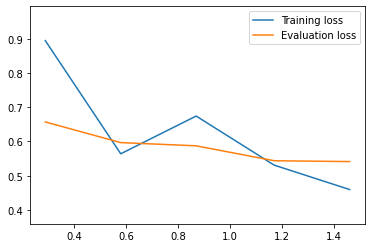

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs["epoch"], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

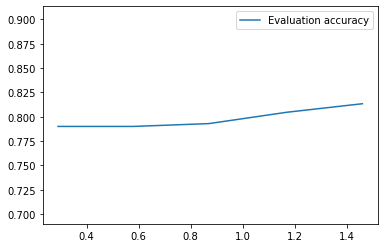

In [22]:
plot(training_logs.logs, ["eval_accuracy"], ["Evaluation accuracy"])